In [1]:
import nrrd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.linear_model import LinearRegression
from scipy.special import comb

In [59]:
IMAGE_PATHS = ['./more_seg/001/Volume_ID_47383217.nrrd', 
               './more_seg/002/Volume_ID_40ed7f97.nrrd', 
               './more_seg/003/Volume_ID_2b0fd57d.nrrd', 
               './more_seg/004/Volume_ID_24708241.nrrd']

SEGMENTATION_PATHS = ['./more_seg/001/ID_47383217_segmentation.seg.nrrd', 
                      './more_seg/002/ID_40ed7f97_segmentation.seg.nrrd', 
                      './more_seg/003/ID_2b0fd57d_segmentation.seg.nrrd',
                      './more_seg/004/ID_24708241_segmentation.seg.nrrd']

# Prepare and visualize image with segmentation

In [68]:
# --- Create color-coded overlay containing segmentation data
def create_segmentation_overlay(segmentation, slice_index):
    colors = {
            0: [0, 0, 0, 0],        # Background (transparent)
            1: [0, 255, 0, 128],    # Anterior falx (green)
            2: [255, 255, 0, 128],    # Posterior falx (yellow)
            3: [255, 165, 0, 128],    # Septum pellucidum (orange)
        }
    # segmentation=np.transpose(segmentation, (1,0,2))
    segmentation_slice = segmentation[:,:,slice_index]
    overlay = np.zeros((segmentation_slice.shape[0], segmentation_slice.shape[1], 4), dtype=np.uint8)
    for label, color in colors.items():
        mask = segmentation_slice == label
        overlay[mask] = color
    return overlay

# --- Intermediate function used to plot a specified slice of image + segmentation
def plot_slices(slice_index, image, segmentation):
    
    image = np.transpose(image, (1,0,2))
    
    overlay = create_segmentation_overlay(segmentation, slice_index)
    overlay = np.transpose(overlay, (1,0,2))
    
    #plt.figure(figsize=(8,8))
    plt.imshow(image[:, :, slice_index], cmap='gray', clim=(0,100))
    plt.imshow(overlay, alpha=0.5)
    plt.title(f"Slice at z = {slice_index}")

# --- Interactive function to slide through image with overlayed segmentation
def imshow(image, segmentation):
    slice_slider = widgets.IntSlider(min=0, max=image.shape[2]-1, step=1, value=0, description='Slice')
    widgets.interact(plot_slices, slice_index=slice_slider, image=fixed(image), segmentation=fixed(segmentation))

# Define visualization functions for line overlay on image

In [4]:
# --- Same as plot_slices, but overlay the intersection of the plane with the image at a specific slice
def plot_slices_with_line_overlay(slice_index, image, segmentation, plane):
    A, B, C, D = plane
    # Equation of plane is given by Ax + By + Cz + D = 0
    # So x = -(By+Cz+D)/A
    # We will find points (x0, 0, slice_index) and (x1, 511, slice_index) and draw a line through them (assuming image is 512 x 512)
    x0 = -(B * 0 + C * slice_index + D)/A
    x1 = -(B * 511 + C * slice_index + D)/A

    plot_slices(slice_index, image, segmentation)   # re-using previous function
    plt.plot([x0, x1], [0, 511], color='red')    # adding line

# --- Interactive function, same as imshow but add intersection of specified plane equation at each slice
def imshow_with_line_overlay(image, segmentation, plane):
    slice_slider = widgets.IntSlider(min=0, max=image.shape[2]-1, step=1, value=0, description='Slice')
    widgets.interact(plot_slices_with_line_overlay, slice_index=slice_slider, image=fixed(image), segmentation=fixed(segmentation), plane=fixed(plane))

# Approach 1: Fit a plane through all points while omitting z coordinates (so plane is orthogonal to xy axis) (Linear Regression)

In [5]:
def fit_plane_1(segmentation):
    anterior_falx = np.argwhere(segmentation==1)
    posterior_falx = np.argwhere(segmentation==2)
    combined_falx = np.vstack((anterior_falx, posterior_falx))
    x_points = combined_falx[:,0].reshape(-1,1)
    y_points = combined_falx[:,1].reshape(-1,1)
    reg = LinearRegression().fit(x_points, y_points)
    a = reg.coef_[0][0]
    b = reg.intercept_[0]
    
    # plane Ax + By + Cz + D = 0
    A = a
    B = -1
    C = 0
    D = b
    plane = (A, B, C, D)
    return plane

# Approach 2: Fit a plane through all points while considering z coordinates (SVD)

In [6]:
def fit_plane_2(segmentation):
    anterior_falx = np.argwhere(segmentation==1)
    posterior_falx = np.argwhere(segmentation==2)
    combined_falx = np.vstack((anterior_falx, posterior_falx))
    
    mean_point = np.mean(combined_falx, axis=0)
    centered_points = combined_falx - mean_point
    U, S, Vt = np.linalg.svd(centered_points)
    normal_vector = Vt[-1]
    
    A, B, C = normal_vector
    D = -np.dot(normal_vector, mean_point)
    
    plane = (A, B, C, D)
    return plane

# Approach 3: Calculate centroid of (x,y) points on anterior and posterior falx and pass line through them

In [35]:
def fit_plane_3(segmentation):
    anterior_falx = np.argwhere(segmentation==1)
    posterior_falx = np.argwhere(segmentation==2)

    anterior_falx_centroid = np.mean(anterior_falx, axis=0)
    posterior_falx_centroid = np.mean(posterior_falx, axis=0)

    af = anterior_falx_centroid[:2]
    pf = posterior_falx_centroid[:2]

    direction = pf - af

    # -- y = mx + b is line through af and pf
    m = direction[1] / direction[0]
    b = af[1] - m * af[0]

    # -- So mx -y = 0z + b = 0
    A = m
    B = -1
    C = 0
    D = b
    
    plane = (A, B, C, D)
    return plane

# Compute and visualize midline shift 

In [8]:
# Distance between point = (x0, y0) and line of equation ax+by+c=0 is given by abs(a * x0 + b*yo + c) / sqrt(a**2 + b**2)
def distance_point_to_line(plane, point):
    x0, y0, z0 = point
    A,B,C,D = plane

    # Eq of plane is: Ax + By + Cz + D = 0
    # Thus, eq of line at z = z0 is: Ax + By + (Cz0 + D) = 0
    distance = abs(A * x0 + B * y0 + (C*z0 + D)) / np.sqrt(A**2 + B**2)
    x_closest = x0 - A * (A * x0 + B * y0 + (C*z0 + D)) / (A**2 + B**2)
    y_closest = y0 - B * (A * x0 + B * y0 + (C*z0 + D)) / (A**2 + B**2)
    closest_point = (x_closest, y_closest)
    distance = distance*0.5 # account for spacing of voxels
    return distance, closest_point

def midline_shift_plot(image, segmentation, plane, closest_point, sp, distance):
    spx, spy, spz = sp
    clpx, clpy = closest_point
    plot_slices_with_line_overlay(int(spz), image, segmentation, plane)
    plt.plot(spx, spy, 'bo')
    plt.plot(clpx, clpy, 'go')
    plt.plot([spx, clpx], [spy, clpy], color='yellow', linestyle='--')
    plt.text(spx, spy-5, f'{distance:.3f}', color='yellow', size=8)
    plt.title(f"Slice at z = {int(spz)}")

# Implement as global post-processing

In [88]:
def calculate_midline_shift(n, approach):
    # read image and segmentation
    ct_image, ct_image_header = nrrd.read(IMAGE_PATHS[n])
    segmentation, segmentation_header = nrrd.read(SEGMENTATION_PATHS[n])
    if approach == 1:
        plane = fit_plane_1(segmentation)
        A,B,C,D = plane
    elif approach == 2:
        plane = fit_plane_2(segmentation)
        A,B,C,D = plane
    elif approach == 3:
        plane = fit_plane_3(segmentation)
        A,B,C,D = plane
        
    print(f"Plane equation: {A:.2f}x + {B:.4f}y + {C:.2f}z + {D:.2f} = 0")

    # imshow_with_line_overlay(ct_image, segmentation, plane)
    
    septum_pellucidum = np.argwhere(segmentation==3)
    sp = np.mean(septum_pellucidum, axis=0)
        
    distance, closest_point = distance_point_to_line(plane, sp)
    midline_shift_plot(ct_image, segmentation, plane, closest_point, sp, distance)
    return {'image':ct_image, 'seg':segmentation, 'plane':plane, 'sp':sp, 'distance':distance, 'closest point':closest_point}

Plane equation: 3.88x + -1.0000y + 0.00z + -991.31 = 0
Plane equation: -5.20x + -1.0000y + 0.00z + 1548.23 = 0
Plane equation: -11.80x + -1.0000y + 0.00z + 3470.08 = 0
Plane equation: 14.69x + -1.0000y + 0.00z + -4419.73 = 0


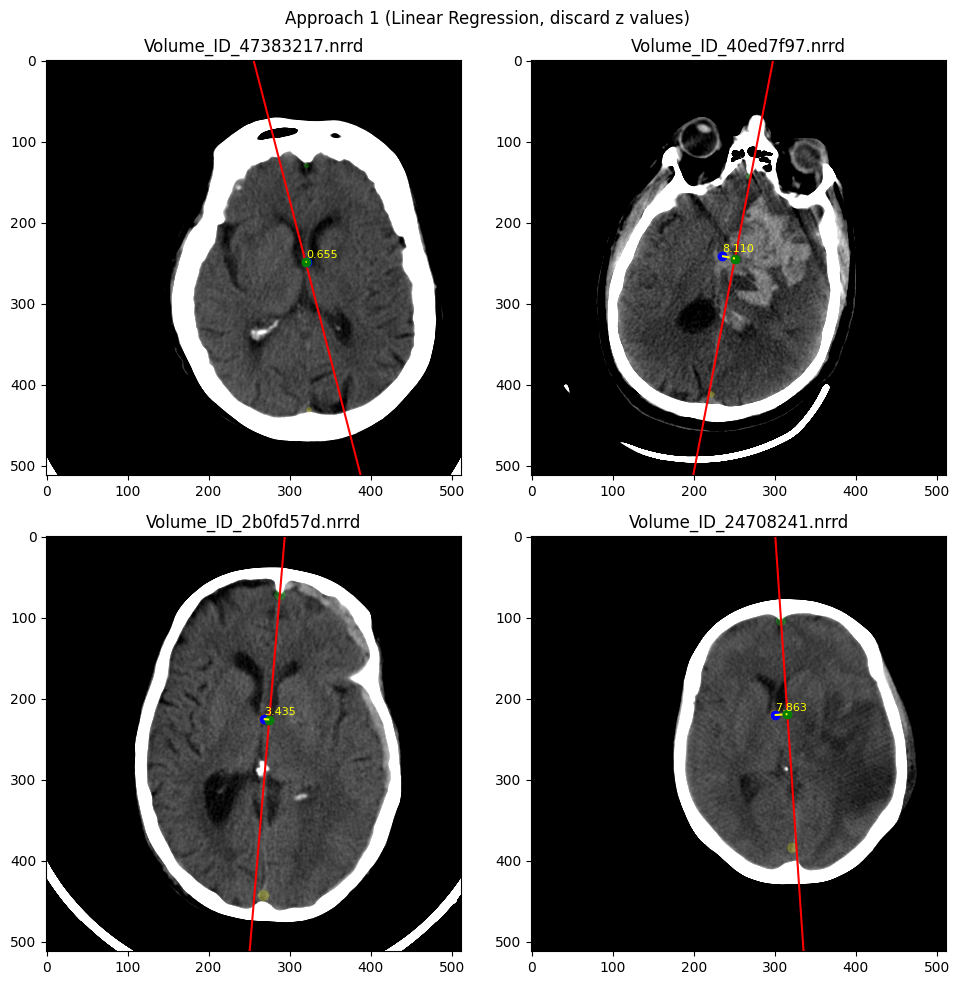

In [89]:
# Approach 1
plt.figure(figsize=(10,10))
for i in range(0,4):
    plt.subplot(2,2,i+1)
    calculate_midline_shift(i, 1)
    plt.title(IMAGE_PATHS[i].split('/')[3])
    plt.suptitle("Approach 1 (Linear Regression, discard z values)")
    plt.tight_layout()

Plane equation: 0.37x + -0.0013y + -0.93z + -101.52 = 0
Plane equation: 0.61x + 0.1075y + -0.78z + -161.89 = 0
Plane equation: 0.23x + 0.0137y + 0.97z + -84.08 = 0
Plane equation: 0.09x + -0.0034y + -1.00z + -14.10 = 0


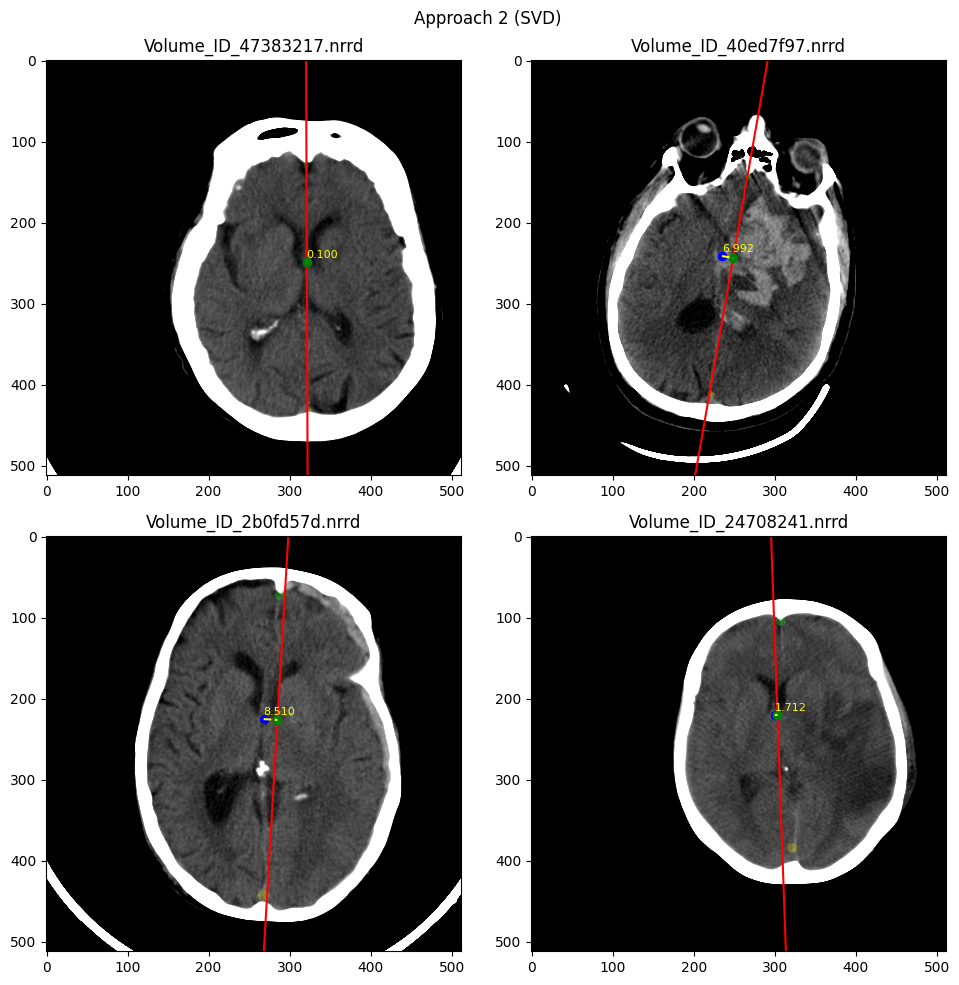

In [90]:
# Approach 2
plt.figure(figsize=(10,10))
for i in range(0,4):
    plt.subplot(2,2,i+1)
    calculate_midline_shift(i, 2)
    plt.title(IMAGE_PATHS[i].split('/')[3])
    plt.suptitle("Approach 2 (SVD)")
    plt.tight_layout()

Plane equation: 130.93x + -1.0000y + 0.00z + -42216.08 = 0
Plane equation: -5.34x + -1.0000y + 0.00z + 1581.51 = 0
Plane equation: -15.64x + -1.0000y + 0.00z + 4504.01 = 0
Plane equation: 18.32x + -1.0000y + 0.00z + -5569.22 = 0


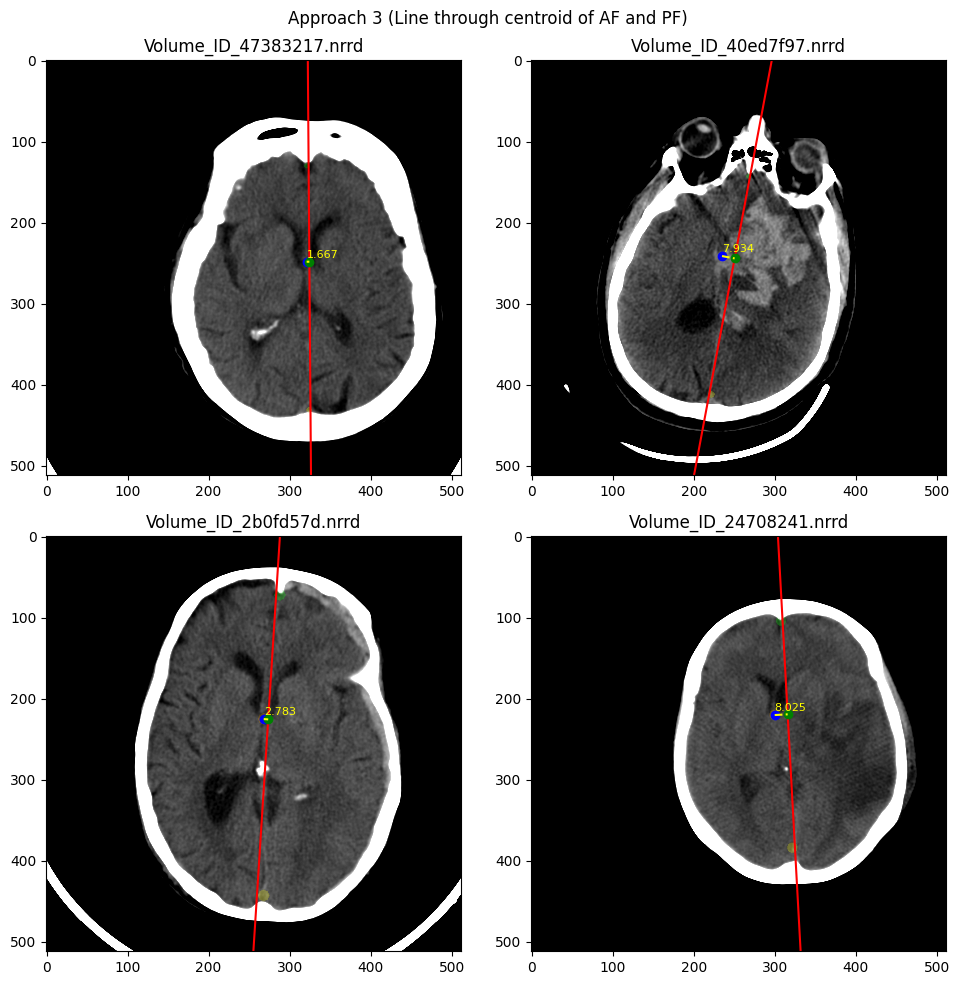

In [91]:
# Approach 3
plt.figure(figsize=(10,10))
for i in range(0,4):
    plt.subplot(2,2,i+1)
    calculate_midline_shift(i, 3)
    plt.title(IMAGE_PATHS[i].split('/')[3])
    plt.suptitle("Approach 3 (Line through centroid of AF and PF)")
    plt.tight_layout()